# Data Import

In [2]:
import pandas as pd
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from geopy.distance import geodesic

from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import mean_absolute_error

from sklearn.neighbors import LocalOutlierFactor

from sklearn.ensemble import IsolationForest

from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

from joblib import dump

from sklearn.decomposition import PCA

from mpl_toolkits.mplot3d import Axes3D

import plotly.graph_objs as go

import dask.dataframe as dd

import gc

import pyarrow

In [3]:
dataset_path = '/kaggle/input/sncb-data-augumentation/augumented_cleaned_ar41_for_ulb.csv'

# Define the columns that you want to load
columns_to_load = [
    'RS_E_InAirTemp_PC1', 'RS_E_InAirTemp_PC2', 
    'RS_E_WatTemp_PC1', 'RS_E_WatTemp_PC2', 
    'RS_T_OilTemp_PC1', 'RS_T_OilTemp_PC2',
    'RS_E_OilPress_PC2', 'RS_E_OilPress_PC2',
    'RS_E_RPM_PC1', 'RS_E_RPM_PC1',
    'Speed', 'lat', 'lon', 'mapped_veh_id', 
    'hour', 'pm10', 'temp_celsius',
    'weather_main', 'date', 'timestamps_UTC'  # Include 'date' to convert to 'weekday' later
]

# Check if the file exists before trying to read it
if os.path.exists(dataset_path):
    # Read the specified columns of the CSV file into a DataFrame
    data = pd.read_csv(dataset_path, usecols=columns_to_load)

    # Display the basic information and the first few rows of the dataframe
    data_info = data.info()
    data_head = data.head()

    # If you want to print the information to the console
    print("Dataframe Info:")
    print(data_info)
    print("\nFirst Few Rows of Data:")
    print(data_head)
else:
    print(f"The file {dataset_path} does not exist.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17677337 entries, 0 to 17677336
Data columns (total 16 columns):
 #   Column              Dtype  
---  ------              -----  
 0   timestamps_UTC      object 
 1   mapped_veh_id       float64
 2   lat                 float64
 3   lon                 float64
 4   RS_E_InAirTemp_PC1  float64
 5   RS_E_InAirTemp_PC2  float64
 6   RS_E_WatTemp_PC1    float64
 7   RS_E_WatTemp_PC2    float64
 8   RS_T_OilTemp_PC1    float64
 9   RS_T_OilTemp_PC2    float64
 10  date                object 
 11  hour                float64
 12  Speed               float64
 13  weather_main        object 
 14  temp_celsius        float64
 15  pm10                float64
dtypes: float64(13), object(3)
memory usage: 2.1+ GB
Dataframe Info:
None

First Few Rows of Data:
        timestamps_UTC  mapped_veh_id    lat   lon  RS_E_InAirTemp_PC1  \
0  2023-01-23 07:25:08          102.0  51.02  3.77                17.0   
1  2023-01-23 07:25:16          102.0  51.02

In [4]:
del data_info
del data_head
gc.collect()

60

In [5]:
# data = data.drop(['Unnamed: 0', 'dayofweek', 'date_hour'], axis=1)

In [6]:
# data.head(500000).to_csv('mini_augumented_cleaned_ar41_for_ulb.csv', index=True)

# Status Label (running | stopped)

In [7]:
stopped_threshold = 10  # Speed less than 10 for being stopped
minimum_stopped_minutes = 30  # Minimum duration for stopped status

In [8]:
# Convert timestamps to datetime and sort
data['timestamps_UTC'] = pd.to_datetime(data['timestamps_UTC'])
data = data.sort_values('timestamps_UTC')

# Calculate time differences in minutes
data['time_diff'] = data['timestamps_UTC'].diff().dt.total_seconds() / 60.0

# Identify rows where the vehicle is stopped
data['is_stopped'] = data['Speed'] < stopped_threshold

# Forward-fill the 'is_stopped' status only within the groups where the vehicle is stopped
data['stopped_group'] = data['is_stopped'].ne(data['is_stopped'].shift()).cumsum()
data.loc[data['is_stopped'], 'stopped_group'] = data.loc[data['is_stopped'], 'stopped_group']

# Calculate the cumulative stopped time in minutes only for stopped groups
data['cumulative_stopped_time'] = data.groupby('stopped_group')['time_diff'].cumsum().fillna(0)

# Determine the stopped groups that exceed the minimum stopped duration
stopped_groups = data[data['cumulative_stopped_time'] > minimum_stopped_minutes]['stopped_group'].unique()

# Mark the status based on the identified stopped groups
data['status'] = 'running'
data.loc[data['stopped_group'].isin(stopped_groups), 'status'] = 'stopped'

In [9]:
data.drop(columns=['time_diff', 'is_stopped', 'stopped_group', 'cumulative_stopped_time', 'timestamps_UTC'], inplace=True)

## Naive Label Anomalous Spot

In [10]:
def label_data(df):
    condition = (
        (df['RS_E_InAirTemp_PC1'] > 65) | (df['RS_E_InAirTemp_PC2'] > 65) |
        (df['RS_E_WatTemp_PC1'] > 100) | (df['RS_E_WatTemp_PC2'] > 100) |
        (df['RS_T_OilTemp_PC1'] > 115) | (df['RS_T_OilTemp_PC2'] > 115)
    )


    df['engine_error_label'] = 0
    df.loc[condition, 'engine_error_label'] = 1

    return df

data = label_data(data)
data

mapped_veh_id    lat   lon  RS_E_InAirTemp_PC1  RS_E_InAirTemp_PC2  \
10309566          160.0  51.04  3.69                14.0                15.0   
10309567          160.0  51.04  3.69                14.0                25.0   
10309568          160.0  51.04  3.69                20.0                30.0   
479843            106.0  50.41  4.52                41.0                41.0   
479844            106.0  50.41  4.52                41.0                41.0   
...                 ...    ...   ...                 ...                 ...   
2319481           115.0  50.14  4.50                38.0                36.0   
16731733          191.0  51.15  4.61                36.0                37.0   
3190108           120.0  50.15  4.50                37.0                31.0   
17418908          196.0  50.42  4.54                18.0                23.0   
16731734          191.0  51.15  4.62                38.0                40.0   

          RS_E_WatTemp_PC1  RS_E_WatTemp_PC2  RS_T_OilTemp_PC1  \
10309566              55.0              75.0              57.0   
10309567              55.0              75.0              55.0   
10309568              55.0              74.0              55.0   
479843                57.0              62.0              58.0   
479844                57.0              62.0              58.0   
...                    ...               ...               ...   
2319481               79.0              82.0              79.0   
16731733              89.0              88.0              89.0   
3190108               78.0              79.0              77.0   
17418908              62.0              62.0              63.0   
16731734              84.0              83.0              87.0   

          RS_T_OilTemp_PC2        date  hour      Speed weather_main  \
10309566              73.0  2023-01-23   2.0   7.465564       Clouds   
10309567              72.0  2023-01-23   2.0   7.465564       Clouds   
10309568              73.0  2023-01-23   2.0   7.465564       Clouds   
479843                62.0  2023-01-23   2.0   7.465564          Fog   
479844                63.0  2023-01-23   2.0   7.465564          Fog   
...                    ...         ...   ...        ...          ...   
2319481               81.0  2023-09-13  21.0   0.142490       Clouds   
16731733              89.0  2023-09-13  21.0   0.832431       Clouds   
3190108               76.0  2023-09-13  21.0   7.386877       Clouds   
17418908              62.0  2023-09-13  21.0   9.456703       Clouds   
16731734              85.0  2023-09-13  21.0  21.875654       Clouds   

          temp_celsius   pm10   status  engine_error_label  
10309566          1.34   9.75  stopped                   0  
10309567          1.42  10.18  stopped                   0  
10309568          1.42  10.18  stopped                   0  
479843            0.03  11.00  stopped                   0  
479844            0.03  11.00  stopped                   0  
...                ...    ...      ...                 ...  
2319481          13.68   3.68  running                   0  
16731733         13.70   6.06  running                   0  
3190108          13.68   3.68  running                   0  
17418908         14.30   3.72  running                   0  
16731734         13.73   6.06  running                   0  

[17677337 rows x 17 columns]

# LSTM Autoencoder

In [11]:
data = data.dropna()

In [12]:
def reduce_mem_usage(df):
    """ Iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if np.issubdtype(col_type, np.number):  # Check if column type is numeric
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type).startswith('int'):
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        # You can add more conditions here for other data types if necessary

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [13]:
# Apply the memory reduction
data = reduce_mem_usage(data)

Memory usage of dataframe is 2400.65 MB


/tmp/ipykernel_129/3704686013.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(np.float16)
/tmp/ipykernel_129/3704686013.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(np.float16)
/tmp/ipykernel_129/3704686013.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

Memory usage after optimization is: 983.60 MB
Decreased by 59.0%


/tmp/ipykernel_129/3704686013.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(np.float16)
/tmp/ipykernel_129/3704686013.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(np.int8)


In [14]:
# Separate numeric and categorical features
numeric_features = [
    'RS_E_InAirTemp_PC1', 'RS_E_InAirTemp_PC2', 
    'RS_E_WatTemp_PC1', 'RS_E_WatTemp_PC2', 
    'RS_T_OilTemp_PC1', 'RS_T_OilTemp_PC2', 
    'Speed', 'lat', 'lon', 'mapped_veh_id', 
    'hour', 'pm10', 'temp_celsius'
]
categorical_features = ['weather_main', 'status']

# Convert 'weekday' to a numerical format
data['weekday'] = pd.to_datetime(data['date']).dt.dayofweek
numeric_features.append('weekday')

# Standardize numeric features
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(data[numeric_features])

# Encode categorical features
encoder = OneHotEncoder(sparse=False)
X_categorical_encoded = encoder.fit_transform(data[categorical_features])

# Combine numeric and categorical data
X_combined = np.hstack((X_numeric_scaled, X_categorical_encoded))

del X_numeric_scaled
del X_categorical_encoded
gc.collect()

def batch_generator(data, sequence_length, batch_size, n_features):
    num_batches = int(np.ceil((data.shape[0] - sequence_length) / batch_size))
    while True:  # Loop forever so the generator never terminates
        for batch_index in range(num_batches):
            start_index = batch_index * batch_size
            end_index = start_index + sequence_length + batch_size - 1  # Adjusted end_index calculation
            
            # Ensure we do not go past the end of the data
            end_index = min(end_index, data.shape[0] - 1)
            
            batch_data = data[start_index:end_index]

            # Adjust batch size if we're at the end and have less than a full batch left
            current_batch_size = min(batch_size, data.shape[0] - start_index - sequence_length)
            X_batch = np.zeros((current_batch_size, sequence_length, n_features))
            y_batch = np.zeros((current_batch_size, n_features))

            for i in range(current_batch_size):
                end_seq_index = i + sequence_length
                # Make sure we don't go beyond the end of batch_data when creating the sequence
                if end_seq_index < batch_data.shape[0]:
                    X_batch[i] = batch_data[i:end_seq_index]
                    y_batch[i] = batch_data[end_seq_index]
                else:
                    # If not enough data for a full sequence, break the loop early
                    break

            yield X_batch, y_batch

# Assuming data is already loaded and preprocessed
n_features = X_combined.shape[1]  # Number of features

# Define sequence length (the window size) and batch size
sequence_length = 10  # This is a hyperparameter you can tune
# batch_size = 128  # Also a tunable hyperparameter
batch_size = 1024 

# Split the data into train and test sets
train_size = int(len(X_combined) * 0.8)
train_data = X_combined[:train_size]
test_data = X_combined[train_size:]

# Create the batch generators
train_generator = batch_generator(train_data, sequence_length, batch_size, n_features)
test_generator = batch_generator(test_data, sequence_length, batch_size, n_features)

/tmp/ipykernel_129/3431622658.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['weekday'] = pd.to_datetime(data['date']).dt.dayofweek
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(units=64, input_shape=(sequence_length, n_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(n_features))

model.compile(optimizer='adam', loss='mae')

In [ ]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
# Train the model using the generators
steps_per_epoch = np.ceil(train_size / batch_size)
validation_steps = np.ceil((len(X_combined) - train_size) / batch_size)

In [ ]:
model.fit(train_generator,
          steps_per_epoch=steps_per_epoch,
          validation_data=test_generator,
          validation_steps=validation_steps,
          epochs=100,
          callbacks=[early_stopping, model_checkpoint])

In [74]:
del train_generator
del test_generator
gc.collect()

1104

In [ ]:
# Save the model
model.save('lstm_autoencoder_model.h5')

In [15]:
# model_path = '/kaggle/input/lstm-anomely-detection/lstm_autoencoder_model.h5'

# model = load_model(model_path)

In [16]:
data

mapped_veh_id       lat       lon  RS_E_InAirTemp_PC1  \
10309566          160.0  51.03125  3.689453                14.0   
10309567          160.0  51.03125  3.689453                14.0   
10309568          160.0  51.03125  3.689453                20.0   
479843            106.0  50.40625  4.519531                41.0   
479844            106.0  50.40625  4.519531                41.0   
...                 ...       ...       ...                 ...   
2319481           115.0  50.12500  4.500000                38.0   
16731733          191.0  51.15625  4.609375                36.0   
3190108           120.0  50.15625  4.500000                37.0   
17418908          196.0  50.40625  4.539062                18.0   
16731734          191.0  51.15625  4.621094                38.0   

          RS_E_InAirTemp_PC2  RS_E_WatTemp_PC1  RS_E_WatTemp_PC2  \
10309566                15.0              55.0              75.0   
10309567                25.0              55.0              75.0   
10309568                30.0              55.0              74.0   
479843                  41.0              57.0              62.0   
479844                  41.0              57.0              62.0   
...                      ...               ...               ...   
2319481                 36.0              79.0              82.0   
16731733                37.0              89.0              88.0   
3190108                 31.0              78.0              79.0   
17418908                23.0              62.0              62.0   
16731734                40.0              84.0              83.0   

          RS_T_OilTemp_PC1  RS_T_OilTemp_PC2        date  hour      Speed  \
10309566              57.0              73.0  2023-01-23   2.0   7.464844   
10309567              55.0              72.0  2023-01-23   2.0   7.464844   
10309568              55.0              73.0  2023-01-23   2.0   7.464844   
479843                58.0              62.0  2023-01-23   2.0   7.464844   
479844                58.0              63.0  2023-01-23   2.0   7.464844   
...                    ...               ...         ...   ...        ...   
2319481               79.0              81.0  2023-09-13  21.0   0.142456   
16731733              89.0              89.0  2023-09-13  21.0   0.832520   
3190108               77.0              76.0  2023-09-13  21.0   7.386719   
17418908              63.0              62.0  2023-09-13  21.0   9.453125   
16731734              87.0              85.0  2023-09-13  21.0  21.875000   

         weather_main  temp_celsius       pm10   status  engine_error_label  \
10309566       Clouds      1.339844   9.750000  stopped                   0   
10309567       Clouds      1.419922  10.179688  stopped                   0   
10309568       Clouds      1.419922  10.179688  stopped                   0   
479843            Fog      0.029999  11.000000  stopped                   0   
479844            Fog      0.029999  11.000000  stopped                   0   
...               ...           ...        ...      ...                 ...   
2319481        Clouds     13.679688   3.679688  running                   0   
16731733       Clouds     13.703125   6.058594  running                   0   
3190108        Clouds     13.679688   3.679688  running                   0   
17418908       Clouds     14.296875   3.720703  running                   0   
16731734       Clouds     13.726562   6.058594  running                   0   

          weekday  
10309566        0  
10309567        0  
10309568        0  
479843          0  
479844          0  
...           ...  
2319481         2  
16731733        2  
3190108         2  
17418908        2  
16731734        2  

[17480997 rows x 18 columns]

In [17]:
def data_generator(data, sequence_length, batch_size):
    num_samples = len(data) - sequence_length
    for start_idx in range(0, num_samples, batch_size):
        end_idx = start_idx + sequence_length + batch_size
        end_idx = min(end_idx, len(data))
        yield data[start_idx:end_idx]

batch_size = 2**14 

generator = data_generator(X_combined, sequence_length, batch_size)
for batch_data in generator:
    X_batch = np.array([batch_data[i:i + sequence_length] for i in range(len(batch_data) - sequence_length)])
    if len(X_batch) == 0:
        continue
    X_batch_pred = model.predict(X_batch, batch_size=batch_size)

    X_batch_last_step = X_batch[:, -1, :]
    batch_error = np.mean(np.abs(X_batch_pred - X_batch_last_step), axis=1)

    threshold = np.quantile(batch_error, 0.97)
    outliers_batch = batch_error > threshold

    # 计算 sequence_end_indices 并确保不超出 data 的索引范围
    start_index = len(data) - len(batch_data) + sequence_length
    sequence_end_indices = np.arange(start_index, start_index + len(X_batch))
    valid_indices = sequence_end_indices[sequence_end_indices < len(data)]
    
    # 更新 data 中的 lstm_outlier 列
    data.loc[valid_indices, 'lstm_outlier'] = outliers_batch[:len(valid_indices)]

    del X_batch, X_batch_pred, batch_error, outliers_batch
    gc.collect()

print(data['lstm_outlier'].value_counts())

1/1 [==============================] - 3s 3s/step


/tmp/ipykernel_129/2299801225.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[valid_indices, 'lstm_outlier'] = outliers_batch[:len(valid_indices)]


1/1 [==============================] - 1s 686ms/step
lstm_outlier
False    15878
True       506
Name: count, dtype: int64


In [18]:
data

mapped_veh_id       lat       lon  RS_E_InAirTemp_PC1  \
10309566          160.0  51.03125  3.689453                14.0   
10309567          160.0  51.03125  3.689453                14.0   
10309568          160.0  51.03125  3.689453                20.0   
479843            106.0  50.40625  4.519531                41.0   
479844            106.0  50.40625  4.519531                41.0   
...                 ...       ...       ...                 ...   
2319481           115.0  50.12500  4.500000                38.0   
16731733          191.0  51.15625  4.609375                36.0   
3190108           120.0  50.15625  4.500000                37.0   
17418908          196.0  50.40625  4.539062                18.0   
16731734          191.0  51.15625  4.621094                38.0   

          RS_E_InAirTemp_PC2  RS_E_WatTemp_PC1  RS_E_WatTemp_PC2  \
10309566                15.0              55.0              75.0   
10309567                25.0              55.0              75.0   
10309568                30.0              55.0              74.0   
479843                  41.0              57.0              62.0   
479844                  41.0              57.0              62.0   
...                      ...               ...               ...   
2319481                 36.0              79.0              82.0   
16731733                37.0              89.0              88.0   
3190108                 31.0              78.0              79.0   
17418908                23.0              62.0              62.0   
16731734                40.0              84.0              83.0   

          RS_T_OilTemp_PC1  RS_T_OilTemp_PC2        date  hour      Speed  \
10309566              57.0              73.0  2023-01-23   2.0   7.464844   
10309567              55.0              72.0  2023-01-23   2.0   7.464844   
10309568              55.0              73.0  2023-01-23   2.0   7.464844   
479843                58.0              62.0  2023-01-23   2.0   7.464844   
479844                58.0              63.0  2023-01-23   2.0   7.464844   
...                    ...               ...         ...   ...        ...   
2319481               79.0              81.0  2023-09-13  21.0   0.142456   
16731733              89.0              89.0  2023-09-13  21.0   0.832520   
3190108               77.0              76.0  2023-09-13  21.0   7.386719   
17418908              63.0              62.0  2023-09-13  21.0   9.453125   
16731734              87.0              85.0  2023-09-13  21.0  21.875000   

         weather_main  temp_celsius       pm10   status  engine_error_label  \
10309566       Clouds      1.339844   9.750000  stopped                   0   
10309567       Clouds      1.419922  10.179688  stopped                   0   
10309568       Clouds      1.419922  10.179688  stopped                   0   
479843            Fog      0.029999  11.000000  stopped                   0   
479844            Fog      0.029999  11.000000  stopped                   0   
...               ...           ...        ...      ...                 ...   
2319481        Clouds     13.679688   3.679688  running                   0   
16731733       Clouds     13.703125   6.058594  running                   0   
3190108        Clouds     13.679688   3.679688  running                   0   
17418908       Clouds     14.296875   3.720703  running                   0   
16731734       Clouds     13.726562   6.058594  running                   0   

          weekday lstm_outlier  
10309566        0          NaN  
10309567        0          NaN  
10309568        0          NaN  
479843          0          NaN  
479844          0          NaN  
...           ...          ...  
2319481         2          NaN  
16731733        2          NaN  
3190108         2          NaN  
17418908        2          NaN  
16731734        2          NaN  

[17480997 rows x 19 columns]

In [26]:
data['lstm_outlier_updated'] = np.nan

for i in range(len(data) - sequence_length + 1):
    try:
        if data.loc[i + sequence_length - 1, 'lstm_outlier'] == 1:
            data.loc[i:i + sequence_length - 1, 'lstm_outlier_updated'] = 1
    except KeyError:
        continue

data['lstm_outlier_updated'].fillna(0, inplace=True)

print(data['lstm_outlier_updated'].value_counts())

/tmp/ipykernel_129/1390611358.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['lstm_outlier_updated'] = np.nan


lstm_outlier_updated
0.0    17305030
1.0      175967
Name: count, dtype: int64


/tmp/ipykernel_129/1390611358.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['lstm_outlier_updated'].fillna(0, inplace=True)


# Evaluation of LSTM Autoencoder

In [27]:
data[data['lstm_outlier_updated']==1]

mapped_veh_id       lat       lon  RS_E_InAirTemp_PC1  \
17464605          197.0  50.09375  4.531250                13.0   
528955            106.0  50.40625  4.441406                10.0   
8575846           150.0  50.93750  4.031250                 4.0   
5006438           133.0  50.40625  4.460938                19.0   
231692            103.0  50.09375  4.531250                 4.0   
...                 ...       ...       ...                 ...   
1193463           110.0  50.78125  3.869141                 7.0   
7915356           146.0  50.75000  3.599609                15.0   
5145079           134.0  51.18750  4.820312                 4.0   
15621303          186.0  51.18750  4.820312                39.0   
17480996          197.0  50.31250  4.210938                36.0   

          RS_E_InAirTemp_PC2  RS_E_WatTemp_PC1  RS_E_WatTemp_PC2  \
17464605                20.0              77.0              65.0   
528955                   2.0              60.0              63.0   
8575846                  6.0              67.0              65.0   
5006438                 11.0              76.0              58.0   
231692                   2.0              61.0              67.0   
...                      ...               ...               ...   
1193463                 15.0              58.0              71.0   
7915356                  8.0              75.0              70.0   
5145079                 13.0              78.0              78.0   
15621303                38.0              79.0              82.0   
17480996                40.0              83.0              81.0   

          RS_T_OilTemp_PC1  RS_T_OilTemp_PC2        date  ...     Speed  \
17464605              73.0              65.0  2023-02-28  ...  2.802734   
528955                59.0              62.0  2023-02-28  ...  2.800781   
8575846               65.0              65.0  2023-02-28  ...  2.800781   
5006438               76.0              55.0  2023-02-28  ...  2.796875   
231692                62.0              66.0  2023-02-28  ...  2.796875   
...                    ...               ...         ...  ...       ...   
1193463               57.0              69.0  2023-03-09  ...  2.875000   
7915356               77.0              66.0  2023-03-09  ...  2.875000   
5145079               81.0              77.0  2023-03-09  ...  2.871094   
15621303              78.0              84.0  2023-03-09  ...  2.871094   
17480996              82.0              81.0  2023-03-09  ...  2.871094   

          weather_main temp_celsius       pm10   status engine_error_label  \
17464605         Clear    -2.300781  12.867188  stopped                  0   
528955           Clear    -2.140625  18.359375  stopped                  0   
8575846          Clear    -0.990234  12.632812  stopped                  0   
5006438          Clear    -2.140625  18.359375  stopped                  0   
231692           Clear    -2.300781  16.875000  stopped                  0   
...                ...          ...        ...      ...                ...   
1193463         Clouds     4.359375   8.578125  running                  0   
7915356         Clouds     2.789062  10.773438  running                  0   
5145079           Snow     1.309570  12.187500  running                  0   
15621303          Snow     1.309570  12.187500  running                  0   
17480996        Clouds     8.531250   0.709961  running                  0   

          weekday  lstm_outlier lstm_outlier1 lstm_outlier_updated  
17464605        1           NaN             0                  1.0  
528955          1           NaN             0                  1.0  
8575846         1           NaN             0                  1.0  
5006438         1           NaN             0                  1.0  
231692          1           NaN             0                  1.0  
...           ...           ...           ...                  ...  
1193463         3           NaN         False                  1.0 

## Feature Importance

In [ ]:
# iso_forest.n_features_in_

In [ ]:
# iso_forest.get_params(deep=True)

In [28]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 10, 64)            23040     
                                                                 
 dropout_10 (Dropout)        (None, 10, 64)            0         
                                                                 
 lstm_11 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_11 (Dropout)        (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 25)                825       
                                                                 
Total params: 36,281
Trainable params: 36,281
Non-trainable params: 0
_________________________________________________________________


## Anomaly Score Analysis

In [ ]:
# # Get anomaly scores using the decision_function
# anomaly_scores = iso_forest.decision_function(X_combined)

# # Add anomaly scores to the data
# data['anomaly_score'] = anomaly_scores

# # View the distribution of anomaly scores
# print(data['anomaly_score'].describe())

In [ ]:
# # Histogram of anomaly scores
# plt.hist(data['anomaly_score'], bins=50)
# plt.title('Histogram of Anomaly Scores')
# plt.xlabel('Anomaly Score')
# plt.ylabel('Frequency')
# plt.show()

## Synthetic Data

In [ ]:
# # Create a copy of the dataset to insert synthetic anomalies
# data_synthetic = data.copy()

# # Introduce anomalies (e.g., extremely high values for a particular feature)
# data_synthetic.loc[0:10, 'RS_E_InAirTemp_PC1'] = data_synthetic['RS_E_InAirTemp_PC1'].max() * 10

# # Standardize and encode the synthetic dataset
# X_numeric_scaled_synthetic = scaler.transform(data_synthetic[numeric_features])
# X_categorical_encoded_synthetic = encoder.transform(data_synthetic[categorical_features])
# X_combined_synthetic = np.hstack((X_numeric_scaled_synthetic, X_categorical_encoded_synthetic))

# # Predict using the Isolation Forest model
# synthetic_outliers = iso_forest.predict(X_combined_synthetic)

# # Check if the synthetic anomalies are detected
# print("Detection of Synthetic Anomalies:", synthetic_outliers[0:10])

In [ ]:
# # Free the memory space
# del data_synthetic
# del X_numeric_scaled_synthetic
# del X_categorical_encoded_synthetic
# del X_combined_synthetic
# del synthetic_outliers
# gc.collect()

## Statistics Analysis

In [30]:
data

mapped_veh_id       lat       lon  RS_E_InAirTemp_PC1  \
10309566          160.0  51.03125  3.689453                14.0   
10309567          160.0  51.03125  3.689453                14.0   
10309568          160.0  51.03125  3.689453                20.0   
479843            106.0  50.40625  4.519531                41.0   
479844            106.0  50.40625  4.519531                41.0   
...                 ...       ...       ...                 ...   
2319481           115.0  50.12500  4.500000                38.0   
16731733          191.0  51.15625  4.609375                36.0   
3190108           120.0  50.15625  4.500000                37.0   
17418908          196.0  50.40625  4.539062                18.0   
16731734          191.0  51.15625  4.621094                38.0   

          RS_E_InAirTemp_PC2  RS_E_WatTemp_PC1  RS_E_WatTemp_PC2  \
10309566                15.0              55.0              75.0   
10309567                25.0              55.0              75.0   
10309568                30.0              55.0              74.0   
479843                  41.0              57.0              62.0   
479844                  41.0              57.0              62.0   
...                      ...               ...               ...   
2319481                 36.0              79.0              82.0   
16731733                37.0              89.0              88.0   
3190108                 31.0              78.0              79.0   
17418908                23.0              62.0              62.0   
16731734                40.0              84.0              83.0   

          RS_T_OilTemp_PC1  RS_T_OilTemp_PC2        date  ...      Speed  \
10309566              57.0              73.0  2023-01-23  ...   7.464844   
10309567              55.0              72.0  2023-01-23  ...   7.464844   
10309568              55.0              73.0  2023-01-23  ...   7.464844   
479843                58.0              62.0  2023-01-23  ...   7.464844   
479844                58.0              63.0  2023-01-23  ...   7.464844   
...                    ...               ...         ...  ...        ...   
2319481               79.0              81.0  2023-09-13  ...   0.142456   
16731733              89.0              89.0  2023-09-13  ...   0.832520   
3190108               77.0              76.0  2023-09-13  ...   7.386719   
17418908              63.0              62.0  2023-09-13  ...   9.453125   
16731734              87.0              85.0  2023-09-13  ...  21.875000   

          weather_main temp_celsius       pm10   status engine_error_label  \
10309566        Clouds     1.339844   9.750000  stopped                  0   
10309567        Clouds     1.419922  10.179688  stopped                  0   
10309568        Clouds     1.419922  10.179688  stopped                  0   
479843             Fog     0.029999  11.000000  stopped                  0   
479844             Fog     0.029999  11.000000  stopped                  0   
...                ...          ...        ...      ...                ...   
2319481         Clouds    13.679688   3.679688  running                  0   
16731733        Clouds    13.703125   6.058594  running                  0   
3190108         Clouds    13.679688   3.679688  running                  0   
17418908        Clouds    14.296875   3.720703  running                  0   
16731734        Clouds    13.726562   6.058594  running                  0   

          weekday  lstm_outlier lstm_outlier1 lstm_outlier_updated  
10309566        0           NaN             0                  0.0  
10309567        0           NaN             0                  0.0  
10309568        0           NaN             0                  0.0  
479843          0           NaN             0                  0.0  
479844          0           NaN             0                  0.0  
...           ...           ...           ...                  ...  
2319481         2           NaN          True          

In [31]:
normal_data = data[data['lstm_outlier_updated'] == 0]
anomalous_data = data[data['lstm_outlier_updated'] == 1]

selected_features = ['RS_E_OilPress_PC1', 'RS_E_InAirTemp_PC1', 'Speed', 'lat', 'lon']

summary_normal = normal_data[selected_features].describe()
summary_anomalous = anomalous_data[selected_features].describe()

print("Normal Data Summary:")
print(summary_normal)
print("\nAnomalous Data Summary:")
print(summary_anomalous)

Normal Data Summary:
       RS_E_InAirTemp_PC1         Speed           lat           lon
count          17305030.0  1.730503e+07  1.730503e+07  1.730503e+07
mean                  NaN           NaN           NaN           NaN
std                   0.0  0.000000e+00  0.000000e+00  0.000000e+00
min                  -5.5  0.000000e+00  5.000000e+01  3.570312e+00
25%                  22.0  8.085938e-01  5.078125e+01  3.720703e+00
50%                  32.0  2.281250e+00  5.100000e+01  3.869141e+00
75%                  40.0  3.250000e+00  5.109375e+01  4.539062e+00
max                 122.0  1.198125e+02  5.131250e+01  5.570312e+00

Anomalous Data Summary:
       RS_E_InAirTemp_PC1          Speed           lat            lon
count            175967.0  175967.000000  175967.00000  175967.000000
mean                  NaN            NaN           NaN            NaN
std                   0.0       0.000000       0.00000       0.000000
min                  -1.0       0.000588      50.06250       3

## Visualization

In [33]:
# data_mini = data.head(500000)

In [40]:
anomaly_ratio = 0.01  
normal_ratio = 1 - anomaly_ratio


total_anomalies = data[data['lstm_outlier_updated'] == 1]
total_normals = data[data['lstm_outlier_updated'] == 0]


sample_size = 50000  
anomalies_sample_size = int(sample_size * anomaly_ratio)
normals_sample_size = sample_size - anomalies_sample_size


anomalies_sample = total_anomalies.sample(n=anomalies_sample_size, random_state=1)
normals_sample = total_normals.sample(n=normals_sample_size, random_state=1)


sampled_data = pd.concat([anomalies_sample, normals_sample])


data_mini = sampled_data.sample(frac=1, random_state=1).reset_index(drop=True)

In [41]:
data_mini[data_mini['lstm_outlier_updated']==1]

mapped_veh_id       lat       lon  RS_E_InAirTemp_PC1  \
102            116.0  50.84375  3.599609                28.0   
116            143.0  51.12500  3.630859                37.0   
368            134.0  51.15625  4.738281                10.0   
409            171.0  50.40625  4.429688                26.0   
488            117.0  50.78125  3.869141                43.0   
...              ...       ...       ...                 ...   
49843          130.0  51.15625  4.730469                 8.0   
49875          102.0  51.00000  3.779297                 8.0   
49910          134.0  51.21875  4.421875                13.0   
49939          177.0  51.12500  4.558594                21.0   
49959          104.0  50.56250  4.699219                24.0   

       RS_E_InAirTemp_PC2  RS_E_WatTemp_PC1  RS_E_WatTemp_PC2  \
102                  37.0              83.0              82.0   
116                  38.0              80.0              80.0   
368                  20.0              81.0              79.0   
409                  17.0              80.0              74.0   
488                  40.0              85.0              82.0   
...                   ...               ...               ...   
49843                20.0              78.0              74.0   
49875                30.0              60.0              35.0   
49910                11.0              81.0              79.0   
49939                27.0              77.0              78.0   
49959                36.0              77.0              60.0   

       RS_T_OilTemp_PC1  RS_T_OilTemp_PC2        date  ...      Speed  \
102                87.0              84.0  2023-02-28  ...   2.816406   
116                83.0              79.0  2023-03-09  ...   2.773438   
368                82.0              77.0  2023-02-28  ...   1.865234   
409                74.0              73.0  2023-03-07  ...  38.625000   
488                85.0              85.0  2023-03-08  ...  58.718750   
...                 ...               ...         ...  ...        ...   
49843              77.0              73.0  2023-03-08  ...  29.562500   
49875              57.0              30.0  2023-02-28  ...   2.638672   
49910              82.0              76.0  2023-02-28  ...   3.648438   
49939              75.0              81.0  2023-02-28  ...   2.365234   
49959              77.0              57.0  2023-03-03  ...  20.234375   

       weather_main temp_celsius       pm10   status engine_error_label  \
102           Clear     4.199219   9.507812  running                  0   
116            Snow     1.769531  10.226562  stopped                  0   
368           Clear     2.970703   8.656250  stopped                  0   
409         Drizzle     3.119141   3.759766  running                  0   
488            Rain     2.410156  11.601562  running                  0   
...             ...          ...        ...      ...                ...   
49843          Snow     0.270020   8.312500  running                  0   
49875         Clear    -0.770020  12.343750  stopped                  0   
49910         Clear     5.570312   8.562500  running                  0   
49939         Clear     3.009766   8.867188  stopped                  0   
49959         Clear    -1.309570  30.140625  running                  0   

       weekday  lstm_outlier lstm_outlier1 lstm_outlier_updated  
102          1           NaN         False                  1.0  
116          3           NaN         False                  1.0  
368          1           NaN         False                  1.0  
409          1           NaN         False                  1.0  
488          2           NaN         False                  1.0  
...        ...           ...           ...                  ...  
49843        2           NaN         False                  1.0  
49875        1           NaN         False                  1.0  
49910        1           NaN         False                  1.0  
49939        1     

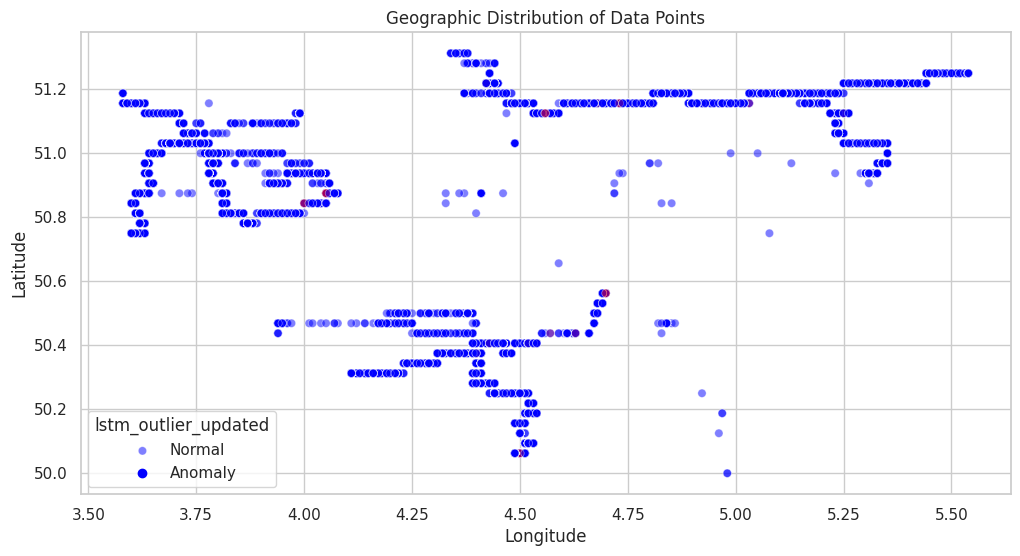

In [42]:
# Setting the aesthetics for the plots
sns.set(style="whitegrid")

# 1. Geographic Distribution
plt.figure(figsize=(12, 6))
sns.scatterplot(x='lon', y='lat', hue='lstm_outlier_updated', data=data_mini, palette=['blue', 'red'], alpha=0.5)
plt.title('Geographic Distribution of Data Points')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='lstm_outlier_updated', labels=['Normal', 'Anomaly'])
plt.show()

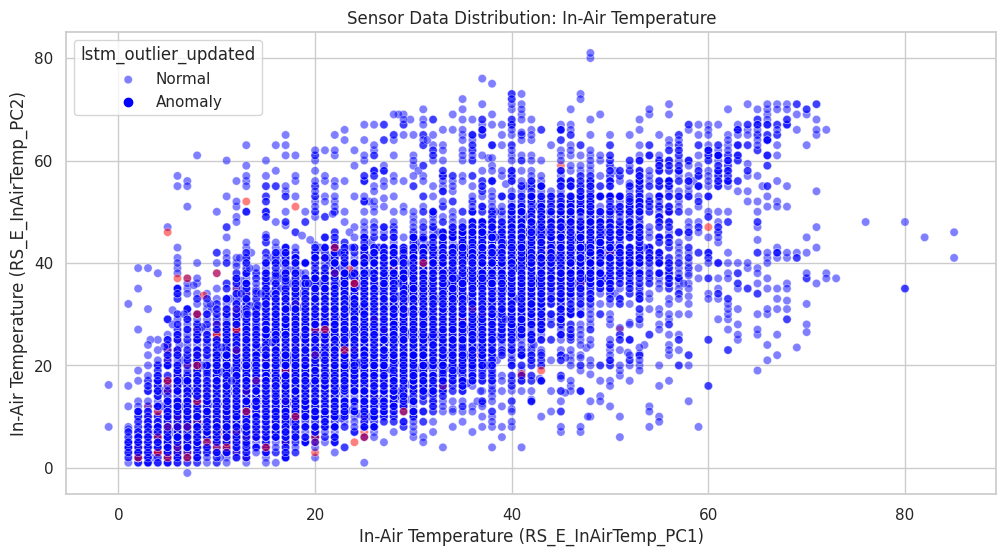

In [43]:
# 2. RS_E_InAirTemp
plt.figure(figsize=(12, 6))
sns.scatterplot(x='RS_E_InAirTemp_PC1', y='RS_E_InAirTemp_PC2', hue='lstm_outlier_updated', data=data_mini, palette=['blue', 'red'], alpha=0.5)
plt.title('Sensor Data Distribution: In-Air Temperature')
plt.xlabel('In-Air Temperature (RS_E_InAirTemp_PC1)')
plt.ylabel('In-Air Temperature (RS_E_InAirTemp_PC2)')
plt.legend(title='lstm_outlier_updated', labels=['Normal', 'Anomaly'])
plt.show()

In [36]:
# 3. RS_E_OilPress
plt.figure(figsize=(12, 6))
sns.scatterplot(x='RS_E_OilPress_PC1', y='RS_E_OilPress_PC2', hue='lstm_outlier_updated', data=data_mini, palette=['blue', 'red'], alpha=0.5)
plt.title('Sensor Data Distribution: Oil Press')
plt.xlabel('Oil Press (RS_E_OilPress_PC1)')
plt.ylabel('Oil Press (RS_E_OilPress_PC1)')
plt.legend(title='lstm_outlier_updated', labels=['Normal', 'Anomaly'])
plt.show()

ValueError: Could not interpret value `RS_E_OilPress_PC1` for parameter `x`

<Figure size 1200x600 with 0 Axes>

In [44]:
# 4. RS_E_RPM
plt.figure(figsize=(12, 6))
sns.scatterplot(x='RS_E_RPM_PC1', y='RS_E_RPM_PC2', hue='lstm_outlier_updated', data=data_mini, palette=['blue', 'red'], alpha=0.5)
plt.title('Sensor Data Distribution: RPM')
plt.xlabel('RPM (RS_E_RPM_PC1)')
plt.ylabel('RPM (RS_E_RPM_PC2)')
plt.legend(title='lstm_outlier_updated', labels=['Normal', 'Anomaly'])
plt.show()

ValueError: Could not interpret value `RS_E_RPM_PC1` for parameter `x`

<Figure size 1200x600 with 0 Axes>

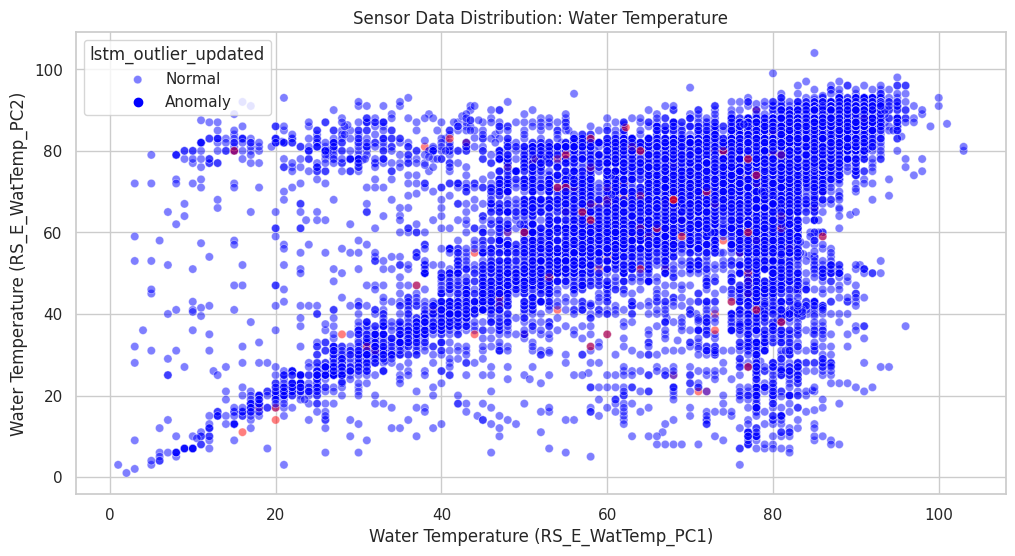

In [45]:
# 5. RS_E_WatTemp
plt.figure(figsize=(12, 6))
sns.scatterplot(x='RS_E_WatTemp_PC1', y='RS_E_WatTemp_PC2', hue='lstm_outlier_updated', data=data_mini, palette=['blue', 'red'], alpha=0.5)
plt.title('Sensor Data Distribution: Water Temperature')
plt.xlabel('Water Temperature (RS_E_WatTemp_PC1)')
plt.ylabel('Water Temperature (RS_E_WatTemp_PC2)')
plt.legend(title='lstm_outlier_updated', labels=['Normal', 'Anomaly'])
plt.show()

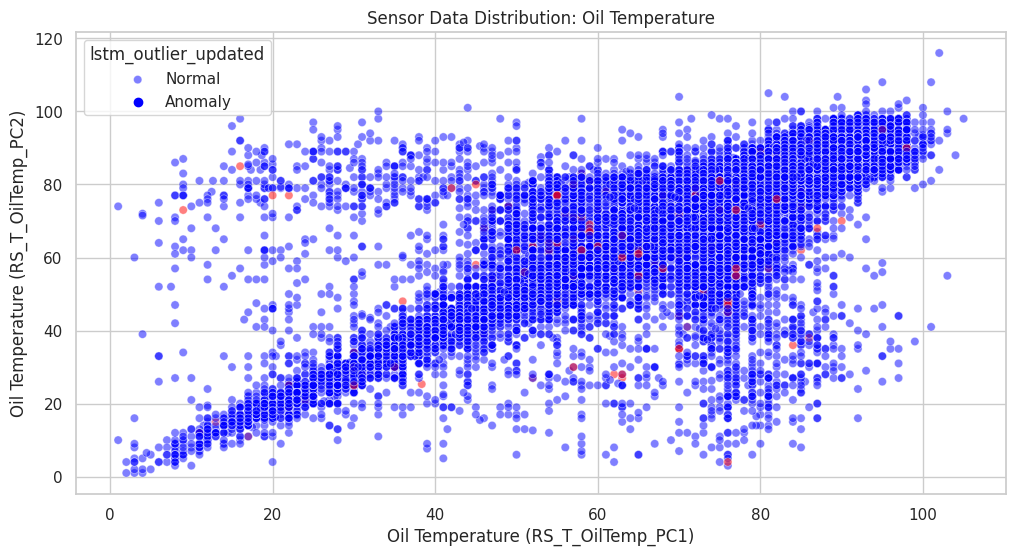

In [46]:
# 6. RS_T_OilTemp_PC1
plt.figure(figsize=(12, 6))
sns.scatterplot(x='RS_T_OilTemp_PC1', y='RS_T_OilTemp_PC2', hue='lstm_outlier_updated', data=data_mini, palette=['blue', 'red'], alpha=0.5)
plt.title('Sensor Data Distribution: Oil Temperature')
plt.xlabel('Oil Temperature (RS_T_OilTemp_PC1)')
plt.ylabel('Oil Temperature (RS_T_OilTemp_PC2)')
plt.legend(title='lstm_outlier_updated', labels=['Normal', 'Anomaly'])
plt.show()

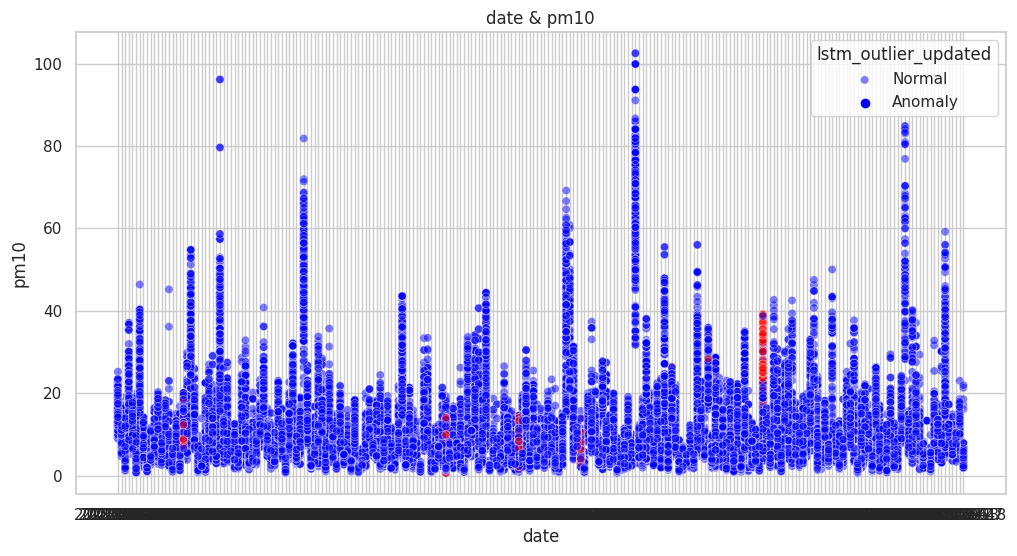

In [47]:
# 7. date & PM 10
plt.figure(figsize=(12, 6))
sns.scatterplot(x='date', y='pm10', hue='lstm_outlier_updated', data=data_mini, palette=['blue', 'red'], alpha=0.5)
plt.title('date & pm10')
plt.xlabel('date')
plt.ylabel('pm10')
plt.legend(title='lstm_outlier_updated', labels=['Normal', 'Anomaly'])
plt.show()

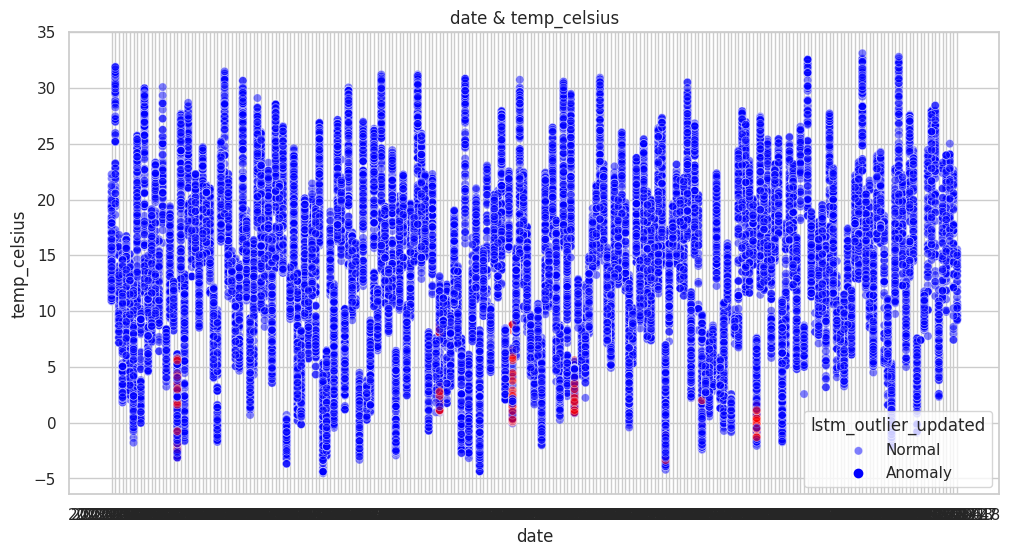

In [51]:
# 8. date & temp_celsius
plt.figure(figsize=(12, 6))
sns.scatterplot(x='date', y='temp_celsius', hue='lstm_outlier_updated', data=data_mini, palette=['blue', 'red'], alpha=0.5)
plt.title('date & temp_celsius')
plt.xlabel('date')
plt.ylabel('temp_celsius')
plt.legend(title='lstm_outlier_updated', labels=['Normal', 'Anomaly'])
plt.show()

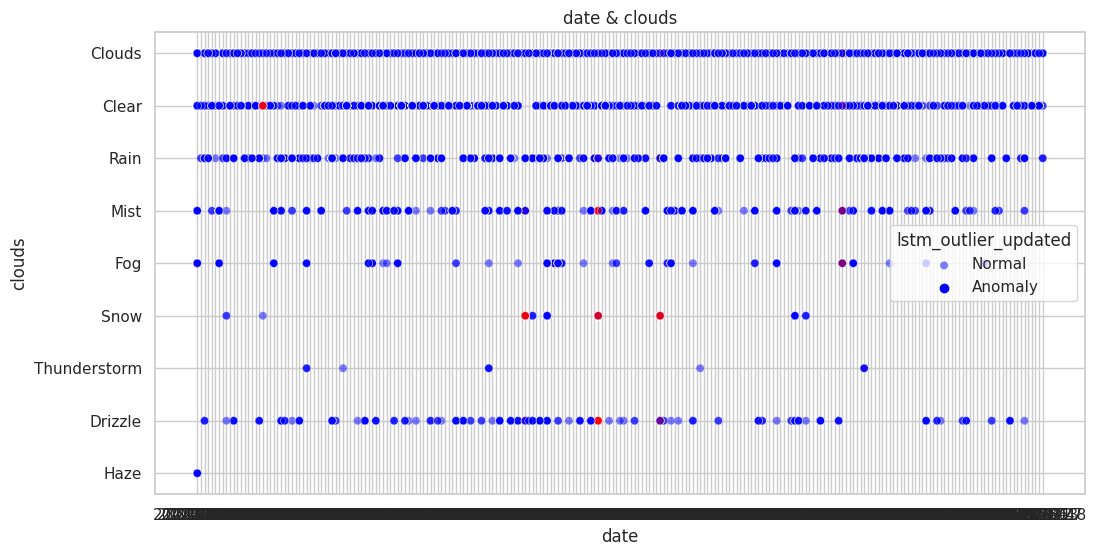

In [50]:
# 8. date & clouds
plt.figure(figsize=(12, 6))
sns.scatterplot(x='date', y='weather_main', hue='lstm_outlier_updated', data=data_mini, palette=['blue', 'red'], alpha=0.5)
plt.title('date & clouds')
plt.xlabel('date')
plt.ylabel('clouds')
plt.legend(title='lstm_outlier_updated', labels=['Normal', 'Anomaly'])
plt.show()

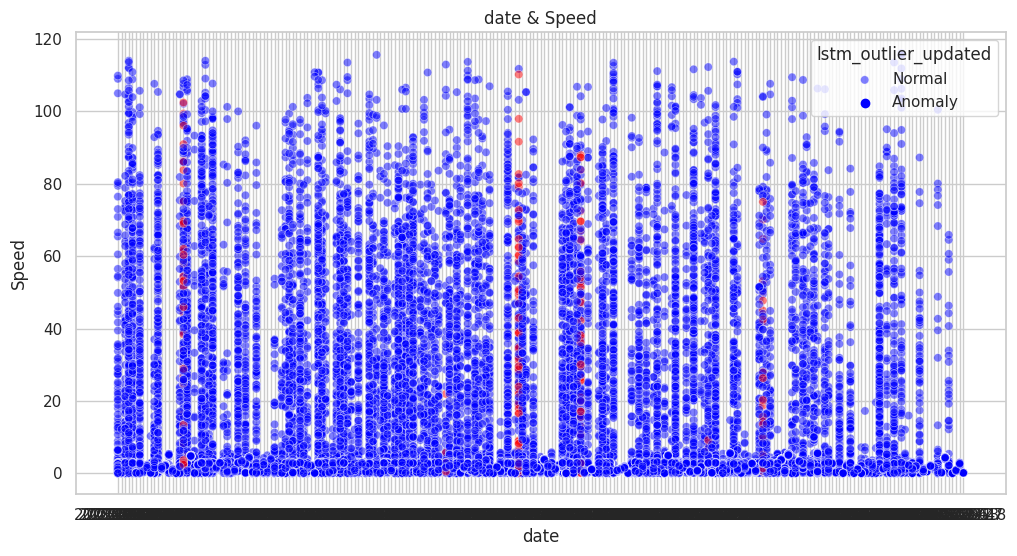

In [52]:
# 9. date & speed
plt.figure(figsize=(12, 6))
sns.scatterplot(x='date', y='Speed', hue='lstm_outlier_updated', data=data_mini, palette=['blue', 'red'], alpha=0.5)
plt.title('date & Speed')
plt.xlabel('date')
plt.ylabel('Speed')
plt.legend(title='lstm_outlier_updated', labels=['Normal', 'Anomaly'])
plt.show()

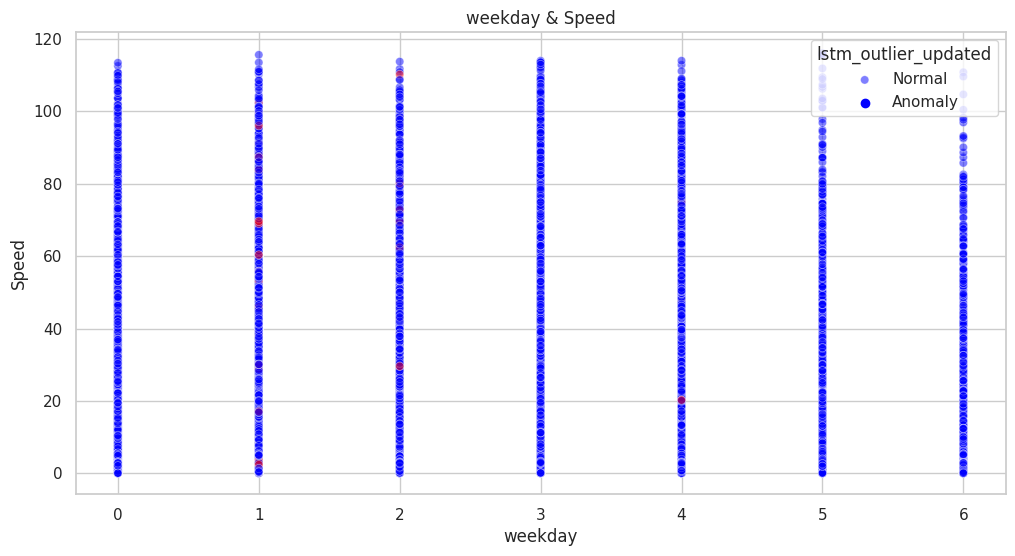

In [53]:
# 9. weekday & speed
plt.figure(figsize=(12, 6))
sns.scatterplot(x='weekday', y='Speed', hue='lstm_outlier_updated', data=data_mini, palette=['blue', 'red'], alpha=0.5)
plt.title('weekday & Speed')
plt.xlabel('weekday')
plt.ylabel('Speed')
plt.legend(title='lstm_outlier_updated', labels=['Normal', 'Anomaly'])
plt.show()

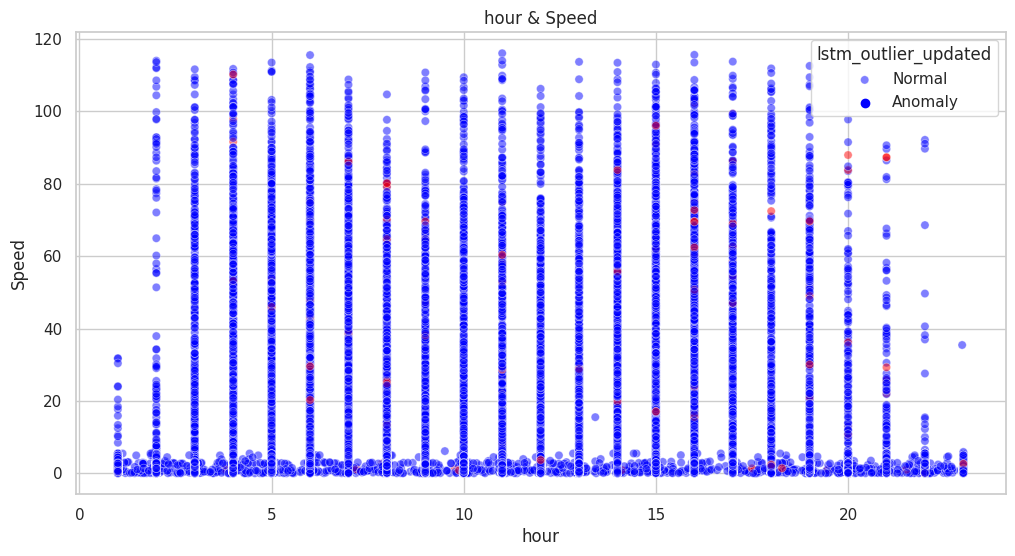

In [54]:
# 10. hour & speed
plt.figure(figsize=(12, 6))
sns.scatterplot(x='hour', y='Speed', hue='lstm_outlier_updated', data=data_mini, palette=['blue', 'red'], alpha=0.5)
plt.title('hour & Speed')
plt.xlabel('hour')
plt.ylabel('Speed')
plt.legend(title='lstm_outlier_updated', labels=['Normal', 'Anomaly'])
plt.show()

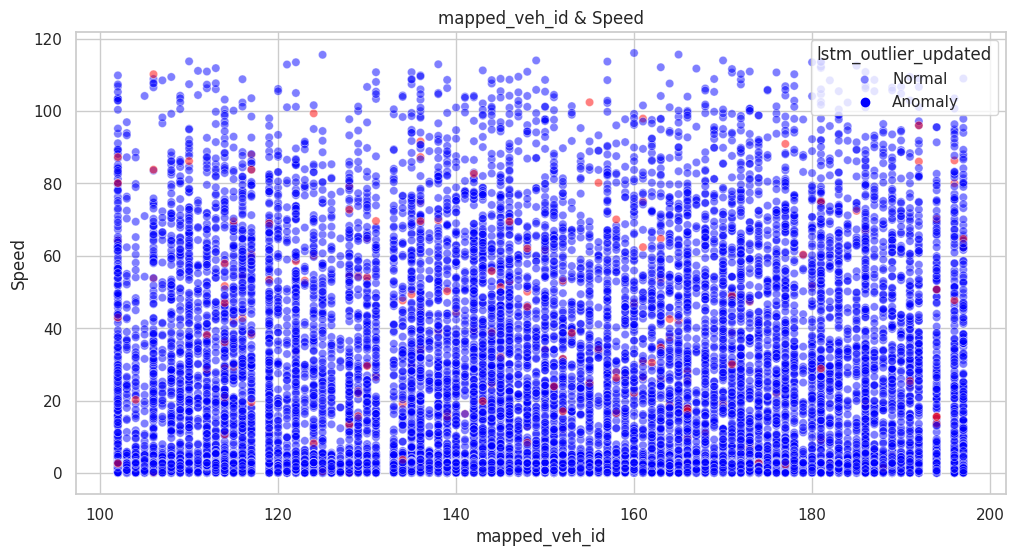

In [55]:
# 11. mapped_veh_id & speed
plt.figure(figsize=(12, 6))
sns.scatterplot(x='mapped_veh_id', y='Speed', hue='lstm_outlier_updated', data=data_mini, palette=['blue', 'red'], alpha=0.5)
plt.title('mapped_veh_id & Speed')
plt.xlabel('mapped_veh_id')
plt.ylabel('Speed')
plt.legend(title='lstm_outlier_updated', labels=['Normal', 'Anomaly'])
plt.show()

In [56]:
# 3. RPM vs. Speed
plt.figure(figsize=(12, 6))
sns.scatterplot(x='RS_E_RPM_PC1', y='Speed', hue='lstm_outlier_updated', data=data_mini, palette=['blue', 'red'], alpha=0.5)
plt.title('Sensor Data Distribution: RPM vs. Speed')
plt.xlabel('RPM (RS_E_RPM_PC1)')
plt.ylabel('Speed')
plt.legend(title='lstm_outlier_updated', labels=['Normal', 'Anomaly'])
plt.show()

# 4. Oil Pressure vs. Speed
plt.figure(figsize=(12, 6))
sns.scatterplot(x='RS_E_OilPress_PC1', y='Speed', hue='lstm_outlier_updated', data=data_mini, palette=['blue', 'red'], alpha=0.5)
plt.title('Sensor Data Distribution: Oil Pressure vs. Speed')
plt.xlabel('Oil Pressure (RS_E_OilPress_PC1)')
plt.ylabel('Speed')
plt.legend(title='lstm_outlier_updated', labels=['Normal', 'Anomaly'])
plt.show()

ValueError: Could not interpret value `RS_E_RPM_PC1` for parameter `x`

<Figure size 1200x600 with 0 Axes>

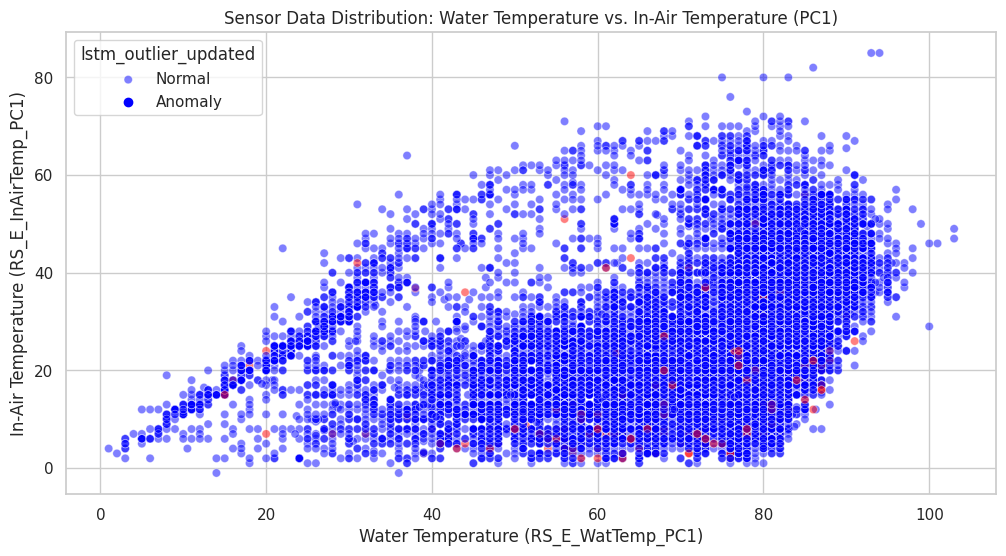

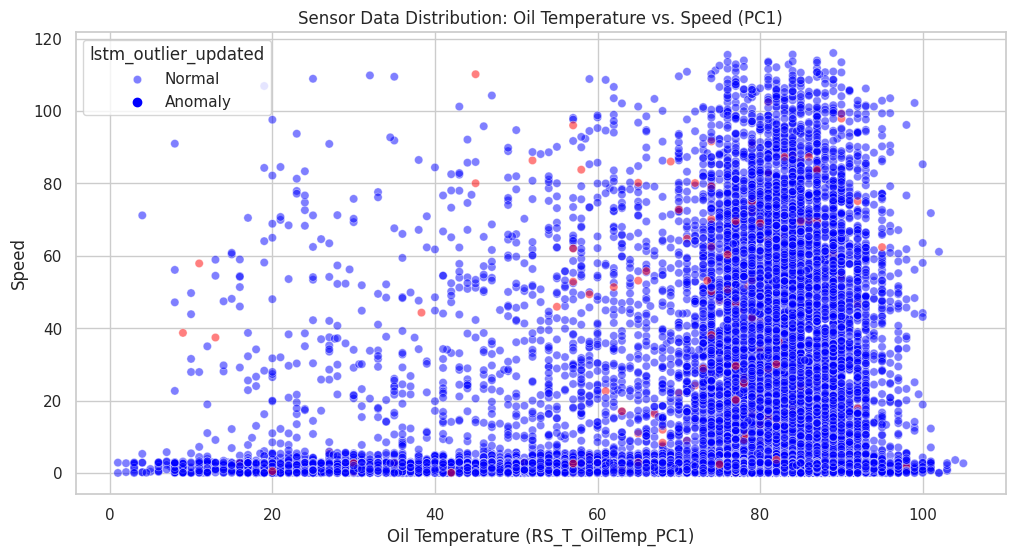

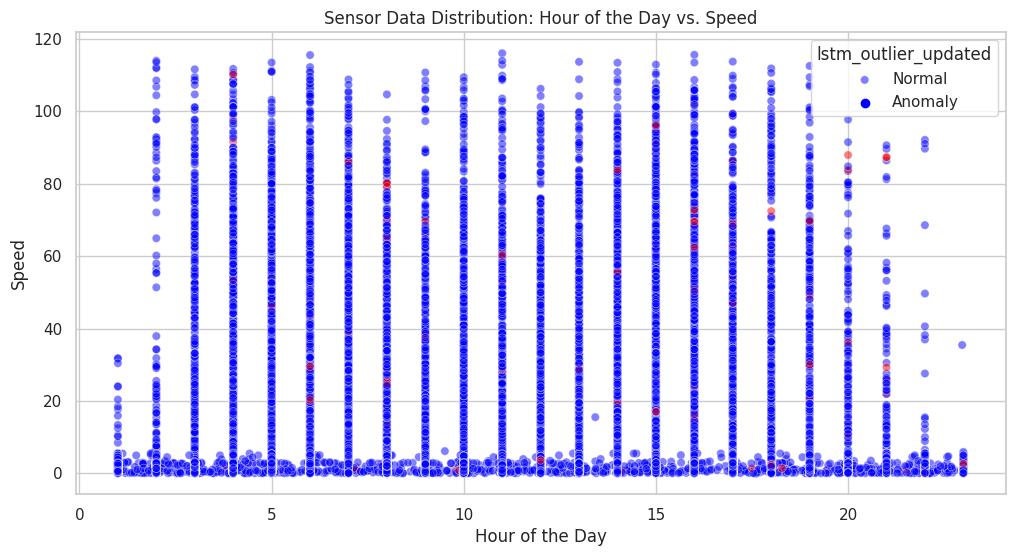

In [57]:
# 5. Water Temperature vs. In-Air Temperature (PC1)
plt.figure(figsize=(12, 6))
sns.scatterplot(x='RS_E_WatTemp_PC1', y='RS_E_InAirTemp_PC1', hue='lstm_outlier_updated', data=data_mini, palette=['blue', 'red'], alpha=0.5)
plt.title('Sensor Data Distribution: Water Temperature vs. In-Air Temperature (PC1)')
plt.xlabel('Water Temperature (RS_E_WatTemp_PC1)')
plt.ylabel('In-Air Temperature (RS_E_InAirTemp_PC1)')
plt.legend(title='lstm_outlier_updated', labels=['Normal', 'Anomaly'])
plt.show()

# 6. Oil Temperature vs. Speed (PC1)
plt.figure(figsize=(12, 6))
sns.scatterplot(x='RS_T_OilTemp_PC1', y='Speed', hue='lstm_outlier_updated', data=data_mini, palette=['blue', 'red'], alpha=0.5)
plt.title('Sensor Data Distribution: Oil Temperature vs. Speed (PC1)')
plt.xlabel('Oil Temperature (RS_T_OilTemp_PC1)')
plt.ylabel('Speed')
plt.legend(title='lstm_outlier_updated', labels=['Normal', 'Anomaly'])
plt.show()

# 7. Hour of the Day vs. Speed
plt.figure(figsize=(12, 6))
sns.scatterplot(x='hour', y='Speed', hue='lstm_outlier_updated', data=data_mini, palette=['blue', 'red'], alpha=0.5)
plt.title('Sensor Data Distribution: Hour of the Day vs. Speed')
plt.xlabel('Hour of the Day')
plt.ylabel('Speed')
plt.legend(title='lstm_outlier_updated', labels=['Normal', 'Anomaly'])
plt.show()

## Contextual Evaluation

In [ ]:
# # Define the temperature thresholds
# thresholds = {
#     'RS_E_InAirTemp_PC1': 65,  # Air temperature threshold in Celsius
#     'RS_E_WatTemp_PC1': 100,  # Water temperature threshold in Celsius
#     'RS_T_OilTemp_PC1': 115   # Oil temperature threshold in Celsius
# }

# # Filter the anomaly records
# anomalous_records = data.loc[data['lstm_outlier_updated'] == -1, list(thresholds.keys()) + ['mapped_veh_id', 'timestamps_UTC']]

# # Function to check if multiple temperatures are high
# def check_multiple_high_temps(row, thresholds):
#     high_temps = {temp: row[temp] > thresholds[temp] for temp in thresholds}
#     # Count how many temperature readings are above the threshold
#     high_temp_count = sum(high_temps.values())
#     # Consider a true problem if more than one temperature reading is high
#     return high_temp_count > 1

# # Apply the function to each anomalous record
# anomalous_records['multiple_high_temps'] = anomalous_records.apply(check_multiple_high_temps, axis=1, thresholds=thresholds)

# # Filter records that are likely true problems
# true_problems = anomalous_records[anomalous_records['multiple_high_temps']]

# # Inspect the records classified as true problems
# print(true_problems)

# Save to CSV

In [ ]:
data.to_csv('labeled_augumented_cleaned_ar41_for_ulb.csv', index=True)